In [1]:
import json
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# list of json files in current directory
instruction_list = glob.glob("data/instruction/*.json")

In [3]:
data_2b = {}
data_350m = {}
data_6b = {}
data_16b = {}
i_2b = 0
i_350m = 0
i_6b = 0
i_16b = 0
for file in instruction_list:
    with open(file, "r") as json_file:
        data = json.load(json_file)
    for i, seed in enumerate(data["permutations"]):
        if len(seed) > 1:
            seed_str = ", ".join(seed)
        else:
            seed_str = seed[0]
            if len(data["fitnesses"][seed_str]) == 0:
                data["fitnesses"][seed_str] = [0]
        # data["fitnesses"][seed_str] = list(set(data["fitnesses"][seed_str]))
        for j in range(len(data["fitnesses"][seed_str])):
            value = {
                "rates": data["rates"][i],
                "fitnesses": data["fitnesses"][seed_str][j],
                "qd_scores": data["qd_scores"][i],
                "niches": data["niches"][i],
                # "valid_stats": data["valid_stats"],
                # "fitness_stats": data["fitness_stats"],
                # "qd_stats": data["qd_stats"],
                "num_seeds": len(data["config"]["seeds"]),
                "seeds": ",".join(data["config"]["seeds"]),
            }
            if "2B" in data["config"]["model"]:
                data_2b[i_2b] = value
                i_2b += 1
            elif "16B" in data["config"]["model"]:
                data_16b[i_16b] = value
                i_16b += 1
            elif "6B" in data["config"]["model"]:
                data_6b[i_6b] = value
                i_6b += 1
            else:
                data_350m[i_350m] = value
                i_350m += 1

In [4]:
df_2b = pd.DataFrame.from_dict(data_2b, orient="index").sort_values(by="num_seeds")
df_350m = pd.DataFrame.from_dict(data_350m, orient="index").sort_values(by="num_seeds")
df_6b = pd.DataFrame.from_dict(data_6b, orient="index").sort_values(by="num_seeds")
df_16b = pd.DataFrame.from_dict(data_16b, orient="index").sort_values(by="num_seeds")

In [5]:
df_2b.groupby("seeds").mean().sort_values(by="fitnesses", ascending=False).groupby("num_seeds").mean()

,rates,fitnesses,qd_scores,niches
num_seeds,,,,
1.0,23.071066,135.264383,3872.299109,22.857143
2.0,8.607082,151.069198,1760.231753,10.344486
3.0,9.921592,147.790706,1972.046048,11.559051


In [6]:
df_350m.groupby("num_seeds").mean()

,rates,fitnesses,qd_scores,niches
num_seeds,,,,
1,42.521063,150.349017,4126.813281,20.453689
2,15.927617,149.197468,1736.018328,9.540541
3,11.052032,152.616395,1553.209595,9.411590


In [7]:
df_2b.groupby("num_seeds").mean()

,rates,fitnesses,qd_scores,niches
num_seeds,,,,
1,48.836397,150.540132,6968.549789,37.461002
2,14.699190,152.841923,1990.225358,10.850649
3,13.888409,151.208616,2292.071084,13.401795


In [8]:
df_6b.groupby("num_seeds").mean()

,rates,fitnesses,qd_scores,niches
num_seeds,,,,
1,55.889982,162.547942,9091.189027,35.798577
2,27.611172,144.180409,2421.045293,14.919846
3,24.901164,145.495639,2604.547141,18.183999


In [9]:
df_16b.groupby("num_seeds").mean()

,rates,fitnesses,qd_scores,niches
num_seeds,,,,
1,65.778219,153.592265,7688.985287,35.369565
2,19.543511,147.595291,2189.407200,12.512469
3,13.474612,143.419134,1234.561960,8.768473


In [112]:
set(df_2b["seeds"].unique()) - set(df_6b["seeds"].unique())

{'cppn_fixed,cppn_mutable,runner'}

In [42]:
sns.set(rc={'figure.figsize':(15, 15)})

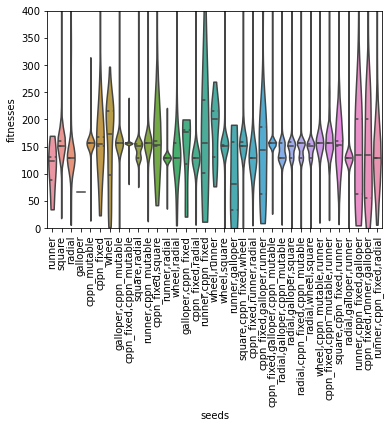

In [10]:
sns.violinplot(x="seeds", y="fitnesses", data=df_2b, inner="quartile", scale="width", cut=0)
_ = plt.xticks(rotation=90)
_ = plt.ylim(0, 400)

<AxesSubplot:xlabel='num_seeds', ylabel='qd_scores'>

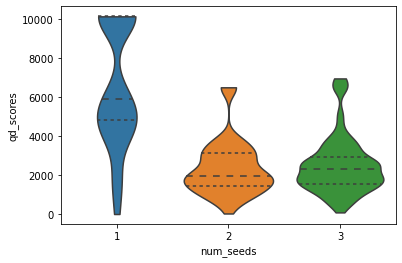

In [95]:
sns.violinplot(x="num_seeds", y="qd_scores", data=df_2b, inner="quartile", cut=0)
# _ = plt.xticks(rotation=90)
# _ = plt.ylim(0, 400)

<AxesSubplot:xlabel='num_seeds', ylabel='niches'>

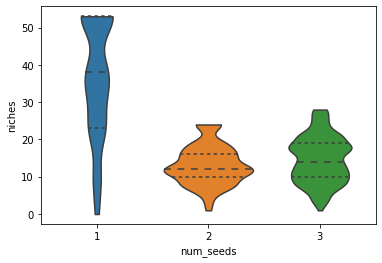

In [96]:
sns.violinplot(x="num_seeds", y="niches", data=df_2b, inner="quartile", cut=0)

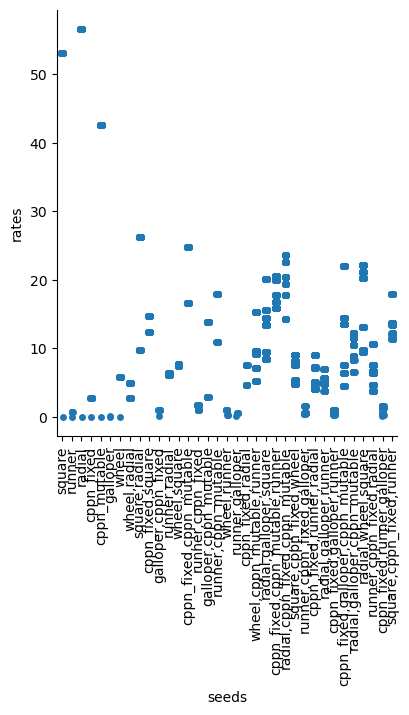

In [6]:
# ax = plt.figure(figsize=(15, 15))
sns.catplot(df_2b, y="rates", x="seeds")
_ = plt.xticks(rotation=90)

(0.0, 500.0)

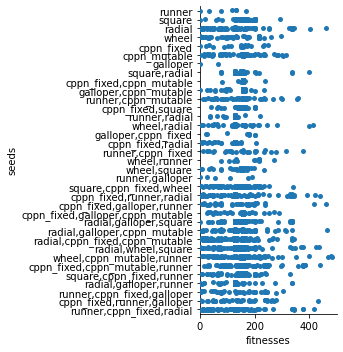

In [15]:
sns.catplot(df_2b, x="fitnesses", y="seeds")
plt.xlim(0, 500)

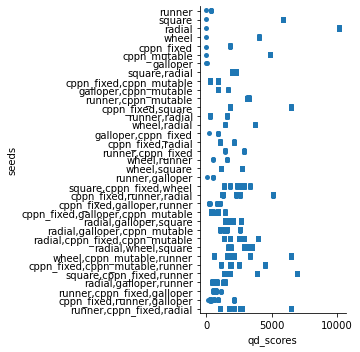

In [16]:
sns.catplot(df_2b, x="qd_scores", y="seeds")

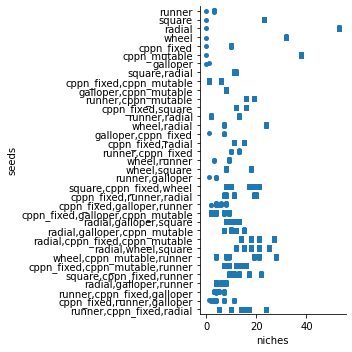

In [17]:
sns.catplot(df_2b, x="niches", y="seeds")